<a href="https://colab.research.google.com/github/heidarimohsen92/Semantic-Segmentation/blob/main/Semantic_Segmentation_for_Self_Driving_Cars_with_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, we are trying to do semantic segmentation for self driving cars.

The [dataset](https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge) provides data images and labeled semantic segmentations captured via CARLA self-driving car simulator.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, concatenate, Activation, MaxPooling2D, UpSampling2D, Input, Dropout


# Download the data

In [2]:
!gdown https://github.com/ongchinkiat/LyftPerceptionChallenge/releases/download/v0.1/carla-capture-20180513A.zip
!unzip -q carla-capture-20180513A.zip

Downloading...
From: https://github.com/ongchinkiat/LyftPerceptionChallenge/releases/download/v0.1/carla-capture-20180513A.zip
To: /content/carla-capture-20180513A.zip
100% 600M/600M [00:06<00:00, 92.1MB/s]


# Data Preparation

In [3]:
# Create Lists of images and masks paths
images_path = sorted( [os.path.join('CameraRGB/' , i) for i in os.listdir('CameraRGB/')] )
masks_path = sorted([os.path.join('CameraSeg/' , i) for i in os.listdir('CameraSeg/')] )

print("number of images is : {} \n".format(len(images_path)))
for input_path, target_path in zip(images_path[:10], masks_path[:10]):
    print(input_path, "|", target_path)

number of images is : 1000 

CameraRGB/F61-1.png | CameraSeg/F61-1.png
CameraRGB/F61-10.png | CameraSeg/F61-10.png
CameraRGB/F61-100.png | CameraSeg/F61-100.png
CameraRGB/F61-11.png | CameraSeg/F61-11.png
CameraRGB/F61-12.png | CameraSeg/F61-12.png
CameraRGB/F61-13.png | CameraSeg/F61-13.png
CameraRGB/F61-14.png | CameraSeg/F61-14.png
CameraRGB/F61-15.png | CameraSeg/F61-15.png
CameraRGB/F61-16.png | CameraSeg/F61-16.png
CameraRGB/F61-17.png | CameraSeg/F61-17.png


In [4]:
#Original labels
labels = ['Unlabeled','Building','Fence','Other',
          'Pedestrian', 'Pole', 'Roadline', 'Road',
          'Sidewalk', 'Vegetation', 'Car','Wall',
          'Traffic sign']

NUM_CLASSES = len(labels)
NUM_CLASSES

13

# ***Splitting the data***

split our data into training, validation and test sets.

In [5]:
# Splitting the data into train, validation and test sets
X_train, X_val, Y_train, Y_val = train_test_split(images_path, masks_path, test_size = 0.20, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size = 0.20, random_state=42)

# Custom Data Generators

Now that we have prepared and splitted our data, we need to define our Generators that are responsible for loading batches of the data and feed them to the model.
Before this step, we will need to defind a function that will be reponsible for loading, and resizing images

In [6]:
# This function will load and resize images and return arrays to the generators
def read_imageMask(image_path, mask_path):
    
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (256, 256), method='nearest')
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    
    return img, mask

In [7]:
# Defining our custom generator
def data_generator(image_paths, mask_paths, batch_size):
    images = tf.constant(image_paths)
    masks = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.map(read_imageMask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.cache().shuffle(500).batch(batch_size)
    
    return dataset

In [8]:
# Now we are ready to create the train, validation and test generators
batch_size = 8
train_generator = data_generator(X_train, Y_train, batch_size)
val_generator = data_generator(X_val, Y_val, batch_size)
test_generator = data_generator(X_test, Y_test, 1)

# Prepare U-Net model

In [9]:
def unet(num_classes = 13, image_shape = (256, 256, 3)):
    # Input
    inputs = Input(image_shape)
    # Encoder Path
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D((2,2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder Path
    up6 = Conv2D(512, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([up6, conv4], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([up7, conv3], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([up8, conv2], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([up9, conv1], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    
    conv10 = Conv2D(num_classes, (1, 1), padding='same', activation='softmax')(conv9)
    
    model = keras.Model(inputs, conv10)
    
    return model

keras.backend.clear_session()
# Create The Model
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

# Compile and Training

In [ ]:
!pip install focal_loss
from focal_loss import SparseCategoricalFocalLoss

In [11]:
# Compile The Model
focal_loss = SparseCategoricalFocalLoss(gamma=2)
model.compile(optimizer=Adam(learning_rate=0.0003), loss=focal_loss, metrics=['accuracy'])

# Define the Callbacks we will use during training
model_path = "save_model/best-unet.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor = "val_loss",
                             mode = "min",
                             verbose = 1,
                             save_best_only = True)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

In [12]:
# Train the Model
history = model.fit(train_generator, validation_data=val_generator,
                    epochs=35, verbose=1, 
                    callbacks=[checkpoint, earlystop])

Epoch 1/35
100/100 [==============================] - ETA: 0s - loss: 0.8165 - accuracy: 0.6254
Epoch 1: val_loss improved from inf to 0.37921, saving model to save_model/best-unet.h5
100/100 [==============================] - 112s 715ms/step - loss: 0.8165 - accuracy: 0.6254 - val_loss: 0.3792 - val_accuracy: 0.8271
Epoch 2/35
100/100 [==============================] - ETA: 0s - loss: 0.2647 - accuracy: 0.8606
Epoch 2: val_loss improved from 0.37921 to 0.22852, saving model to save_model/best-unet.h5
100/100 [==============================] - 67s 670ms/step - loss: 0.2647 - accuracy: 0.8606 - val_loss: 0.2285 - val_accuracy: 0.8819
Epoch 3/35
100/100 [==============================] - ETA: 0s - loss: 0.1794 - accuracy: 0.9019
Epoch 3: val_loss improved from 0.22852 to 0.19530, saving model to save_model/best-unet.h5
100/100 [==============================] - 67s 672ms/step - loss: 0.1794 - accuracy: 0.9019 - val_loss: 0.1953 - val_accuracy: 0.8947
Epoch 4/35
100/100 [=================

# Evaluation

Let's Now Visualize the Results

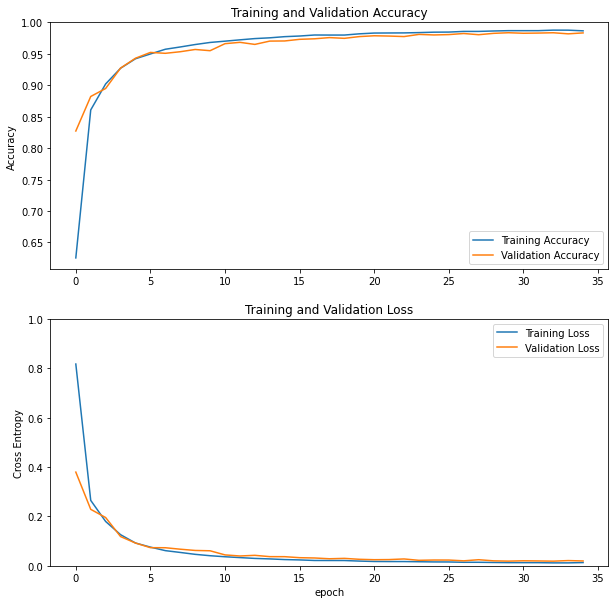

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluate The Model

In [14]:
# Predict on training and validation data
model = load_model("save_model/best-unet.h5") 

train_loss, train_accuracy = model.evaluate(train_generator, batch_size = 8)
validation_loss, validation_accuracy = model.evaluate(val_generator, batch_size = 8)
test_loss, test_accuracy = model.evaluate(test_generator, batch_size = 1)

40/40 [==============================] - 4s 33ms/step - loss: 0.0208 - accuracy: 0.9818


Visualize The results of our Model on test data

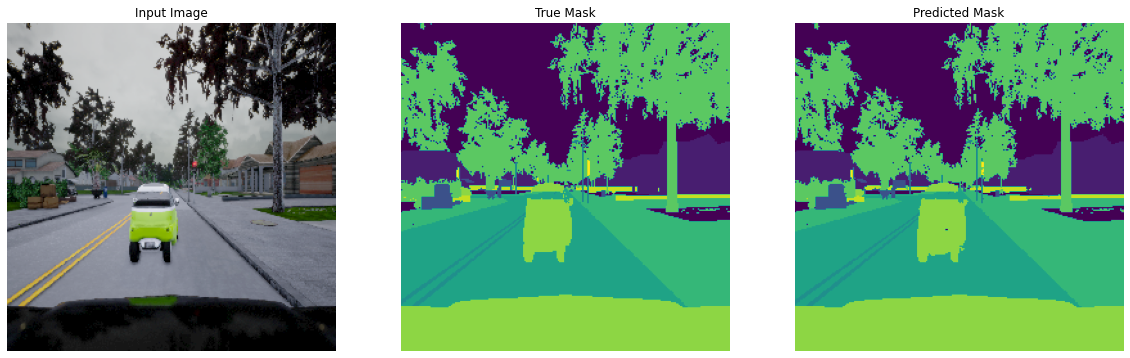

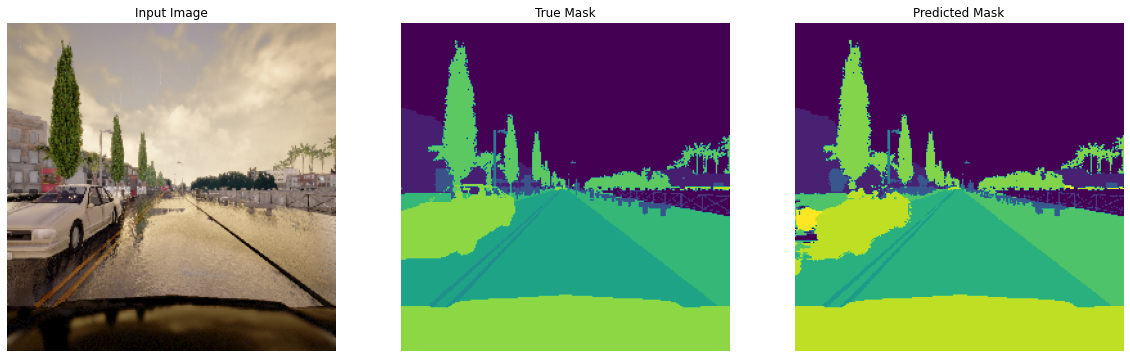

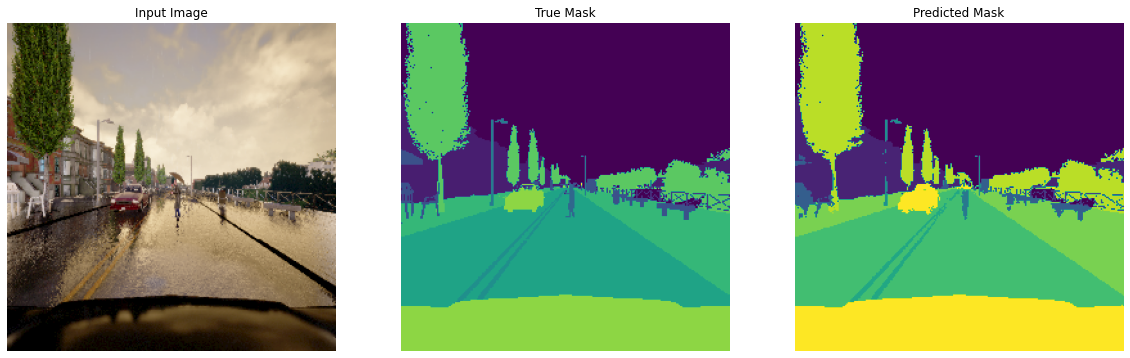

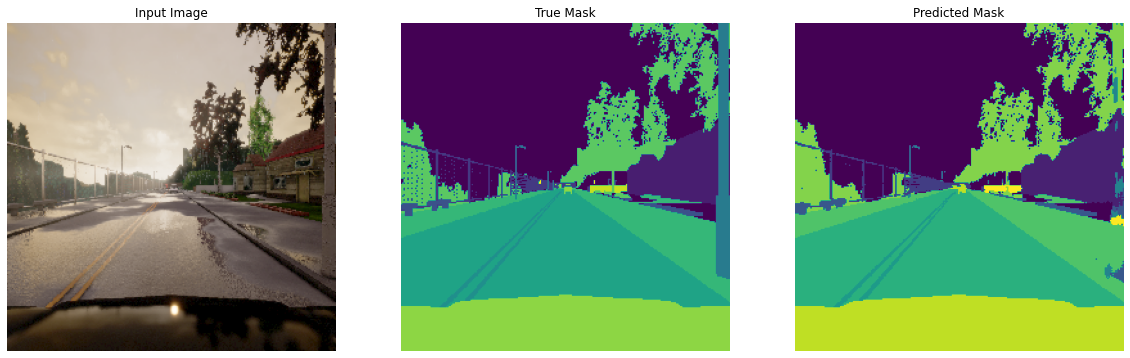

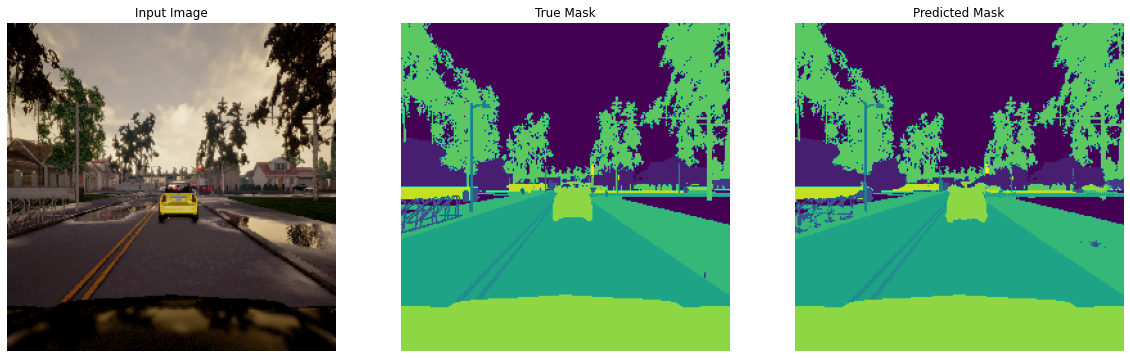

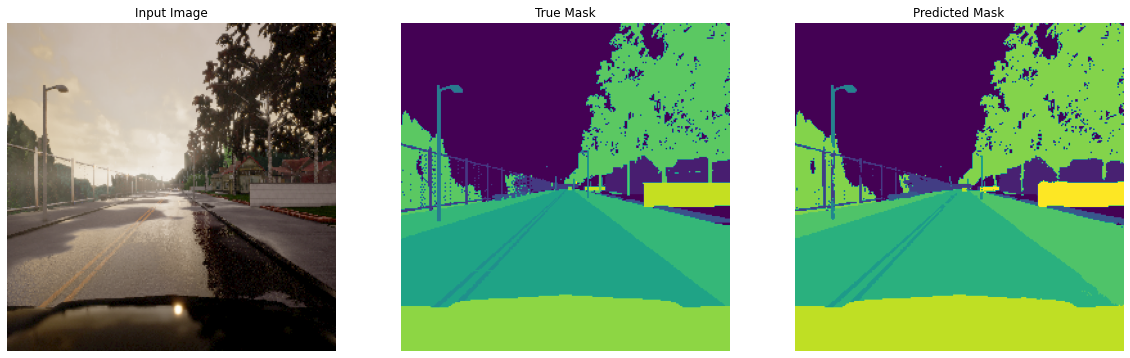

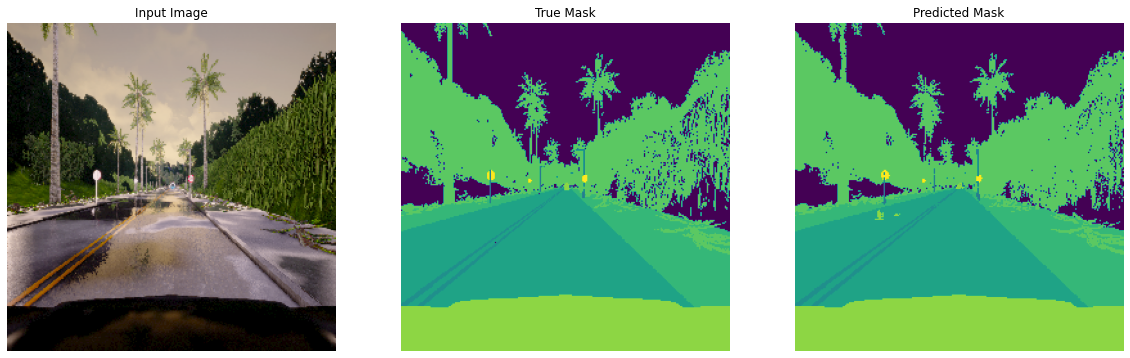

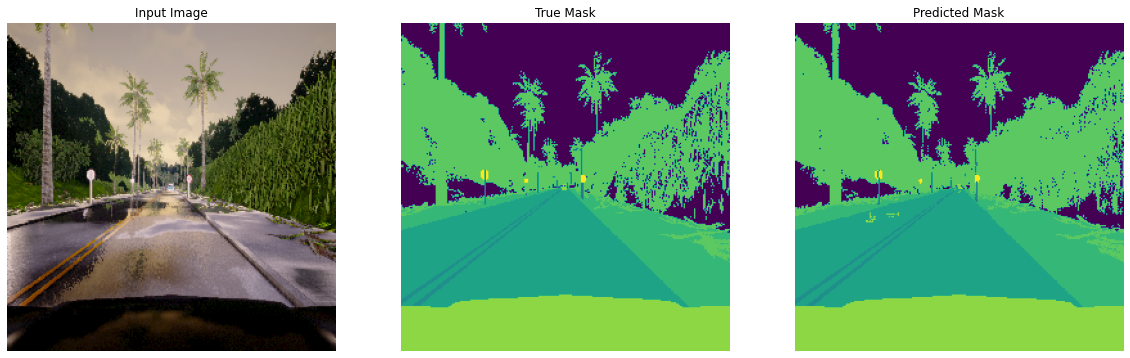

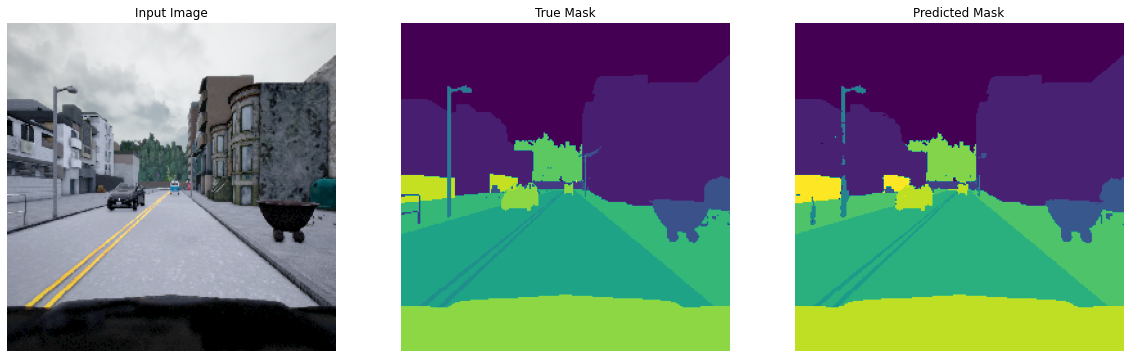

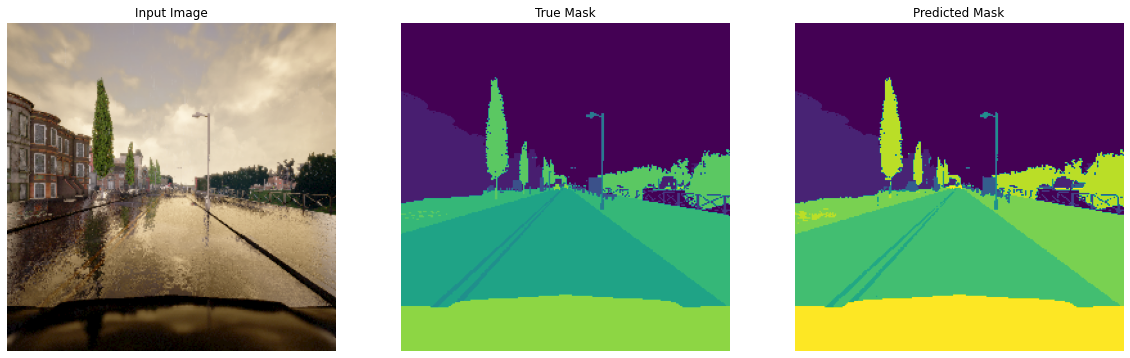

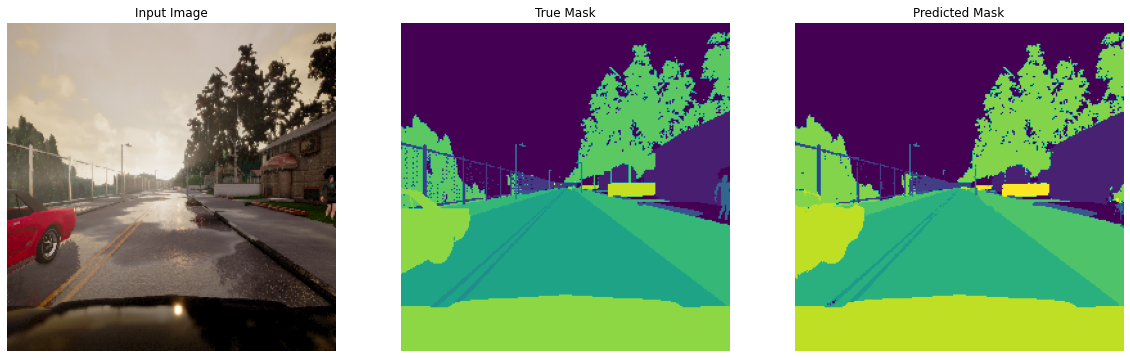

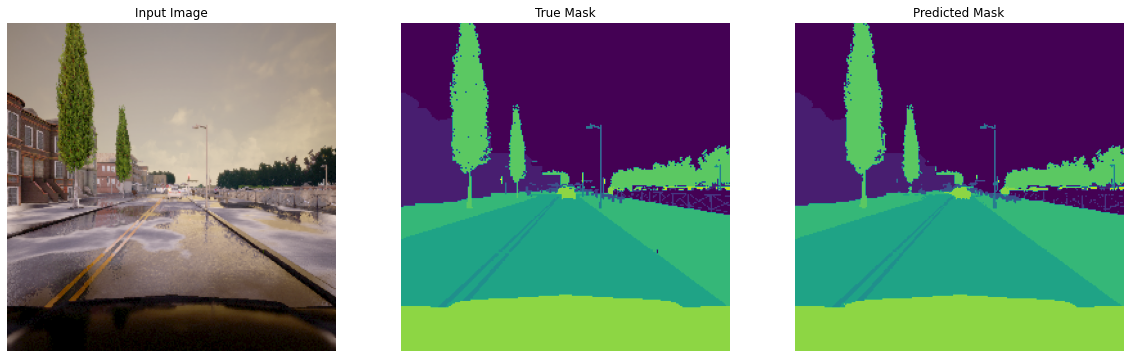

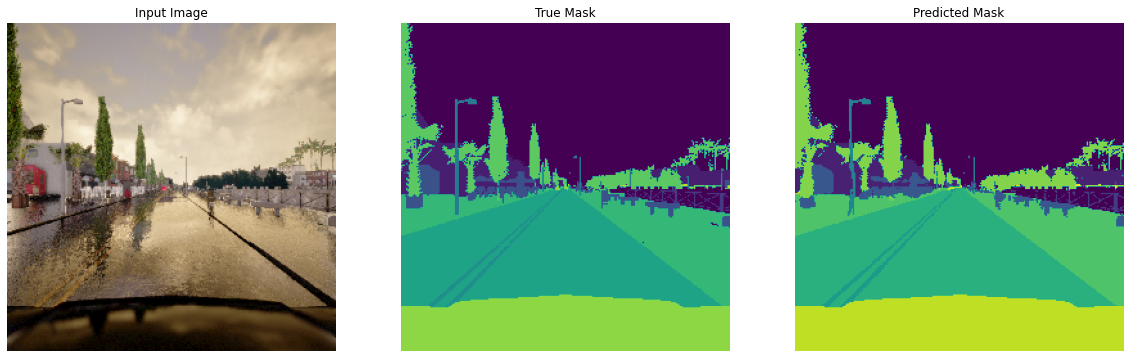

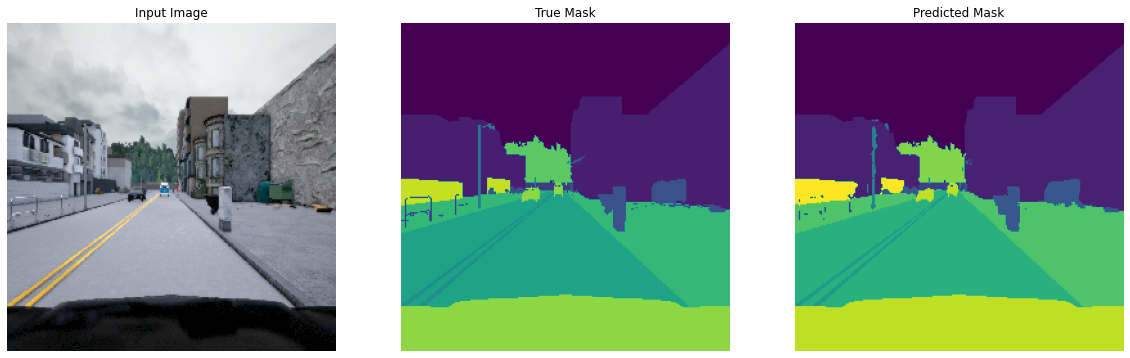

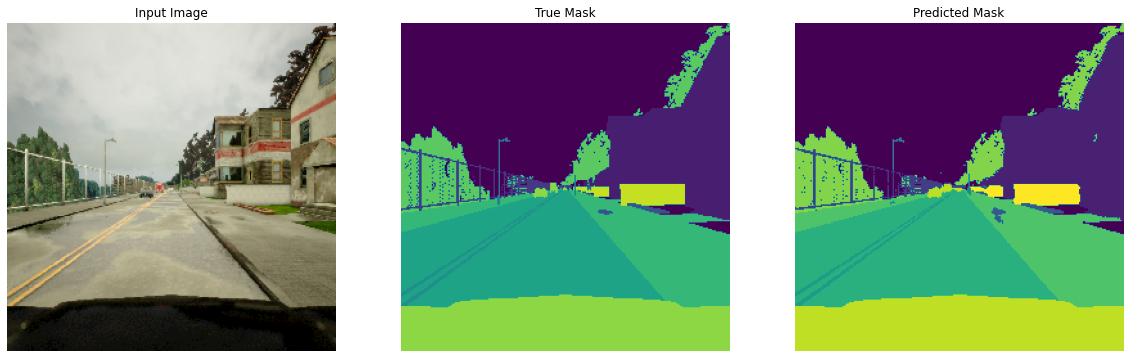

In [16]:
for image, mask in test_generator.take(15):
    pred_mask = model.predict(image)
    
    plt.figure(figsize=(20, 20))
    # Our original image
    plt.subplot(1, 3, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
    plt.title('Input Image')
    plt.axis('off')
    # Our original Mask
    plt.subplot(1, 3, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
    plt.title('True Mask')
    plt.axis('off')
    # Our Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(tf.expand_dims(tf.argmax(pred_mask[0], axis = -1), axis = -1)))
    plt.title('Predicted Mask')
    plt.axis('off')